## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import random
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Path management
main_dir = str(Path(os.path.abspath("")).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [3]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD, load_k_shortest_paths
from pesuelogit.etl import data_curation, add_period_id

# Internal modules
from nesuelogit.models import create_tvodlulpe_model_fresno, compute_generated_trips, compute_generation_factors, \
    create_tvgodlulpe_model_fresno, compute_baseline_predictions_kfold, train_kfold
from nesuelogit.etl import build_network, get_tensors_by_year
from nesuelogit.visualizations import plot_flow_vs_traveltime, plot_congestion_maps, \
    plot_metrics_kfold, plot_parameters_kfold, plot_baselines_kfold
from nesuelogit.metrics import mse, mape, r2_score,  z2score, mdape
from nesuelogit.utils import read_paths, flat_od_from_generated_trips

In [4]:
# Seed for reproducibility
_SEED = 2024
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [5]:
# To report global runtime
t0_global = time.time()

In [6]:
# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 231219160236


### Hyperparameters

In [7]:
# Number of splits for k-fold validation
_N_SPLITS = 5
# Add deviation respect to historic OD matrix for better generalization in k-fold
_LOSS_WEIGHTS_KFOLD = {'tvodlulpe': {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1},
                       'tvgodlulpe': {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}}

# Optimization
_LR = {'tvodlulpe': {'learning': 5e-2, 'equilibrium': 5e-2},
       'tvgodlulpe': {'learning': 1e-1, 'equilibrium': 5e-2, 'generation': 10}}
_RELATIVE_GAP = float('inf') # 1e-2 #
_BATCH_SIZE = 1
_EPOCHS = {'tvodlulpe':{'learning': 20, 'equilibrium': 0},
           'tvgodlulpe':{'learning': 10, 'equilibrium': 0}}
_DTYPE = tf.float32
_OPTIMIZERS = {model: {key: tf.keras.optimizers.legacy.Adam(learning_rate=lr)
                       for key, lr in lrs.items()} for model, lrs in _LR.items()}

# Exogenous attributes in utility function
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

### Other configurations

In [8]:
# _HOURS = [6,7,8, 15,16,17]
_HOURS = np.arange(6,21)
_DAYSOFWEEK = [1,2,3]
_LOSS_METRIC  = z2score
_EVALUATION_METRIC = mdape

model_filepaths = {'tvodlulpe':f'output/models/{231218223519}_fresno_tvodlulpe.h5',
                   'tvgodlulpe':f'output/models/{231218223519}_fresno_tvgodlulpe.h5'}

## Read nodes and link-specific data

In [9]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

## Build network

In [10]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

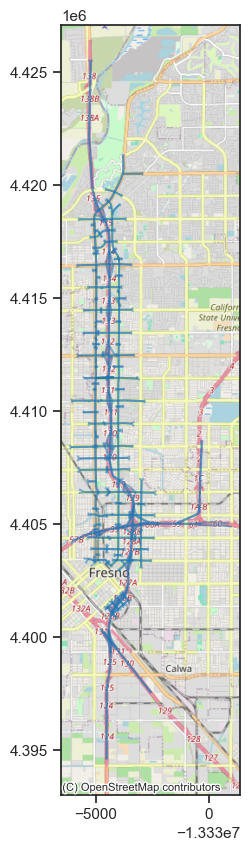

In [11]:
## Display network
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
ax = links_gdf.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()
plt.close()

## Read and load OD matrix

In [12]:
read_OD(network=network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read and load paths

In [13]:
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-fresno-k3.csv')
# read_paths(network=network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

20840 paths were read and incidence matrices were built


## Read and process spatio-temporal link-level data

In [14]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period'], format = '%Y-%m-%d-%H').dt.strftime('%Y-%m-%d-%H')

# Select data from Tuesdays to Thursdays
df = df[df['date'].dt.dayofweek.isin(_DAYSOFWEEK)]

# # Select data from first Tuesdays of 2019 and 2020
# df = df[df['date'].isin(["2019-10-01", "2020-10-06"])]

# # Select countdata from selected links
# selected_links = [(290,169,'0'),(170,168,'0'),(337,692,'0'),(228,192,'0'),(191,171,'0'),(188,87,'0'), (171,290,'0'),(192,191,'0'),(87,228,'0'),(169,332,'0'),(631,635,'0'),(179,183,'0'), (641,86,'0'),(638,634,'0'),(170,207,'0'),(86,189,'0'),(580,142,'0'),(333,332,'0'), (99,43,'0'),(637,639,'0')]
# df.loc[~df.link_key.isin(selected_links),'counts'] = float('nan')

In [15]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [16]:
# Data curation
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

In [17]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd_adj']
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

## Process node-level data

In [18]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Utility function

In [19]:
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

## Data processing

In [20]:
n_links = len(network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year

In [21]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

## EDA

In [22]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [23]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


In [24]:
## Link-level attributes in utility function
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06
mean,1.813680e-02,2.621913e+01,7.441093e-01,1.500207e-01,8.765023e-01
std,2.783112e-02,2.135738e+01,3.193143e+00,4.411927e-01,1.319496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.113761e-02,2.482100e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.548870e-02,4.168100e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,7.459602e-01,1.158930e+02,4.000000e+01,4.000000e+00,9.000000e+00


## Training and validation sets

In [25]:
# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin(_HOURS)], features_Z = _FEATURES_Z, links_keys=list(network.links_dict.keys()))

# Split in training and test sets
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

### Reference O-D matrix and trip generation vectors

In [26]:
q_historic = np.repeat(network.q.flatten()[np.newaxis, :], len(_HOURS), axis=0)

#Adjust historic O-D and historic trip generation
generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

reference_q = q_historic*np.tile(generation_factors.values,(q_historic.shape[1],1)).T

reference_g = compute_generated_trips(q = reference_q, ods= network.ods, n_nodes = len(network.nodes))

# Total trips tvodlulpe pesuelogit:
# Epoch 0: 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04
# Final epoch: 6.4e+04 6.6e+04 6.3e+04 7.8e+04 7.9e+04 7.9e+04
# Growth factor captures the difference between the reference OD at epoch 0 and the estimated OD in Guarda et al., (2024), Transportation Research Part C
# growth_factor = 7.9/6.6
# reference_g = growth_factor*reference_g
# reference_q = growth_factor*reference_q

## Models

In [27]:
train_results_dfs = {}
val_results_dfs = {}
models = {}
inference_models = {}

# Forecasting

## TVGODLULPE

In [28]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_models['tvgodlulpe'] = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z, reference_g = reference_g)
inference_models['tvgodlulpe'].build()
#inference_model.update_predictions(XT_train, update_period_dict = True)

inference_models['tvgodlulpe'].load_weights(model_filepaths['tvgodlulpe'])

ValueError: Cannot assign value to variable ' kappa:0': Shape mismatch.The variable shape (15, 3), and the assigned value shape (15, 6970) are incompatible.

### - Model estimated with all data from 2019

In [ ]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_models['tvgodlulpe'].predict(XT_train,
                                           # period_dict = reference_model.period_dict,
                                           node_data=nodes_df,
                                           loss_metric=_LOSS_METRIC,
                                           pretrain_link_flows = False,
                                           batch_size= _BATCH_SIZE,
                                           optimizer= _OPTIMIZERS['tvgodlulpe']['equilibrium'],
                                           loss_weights={'equilibrium': 1},
                                           threshold_relative_gap=_RELATIVE_GAP,
                                           epochs=100)

In [ ]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_models['tvgodlulpe'].compute_loss_metrics(
        metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score},
        X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = inference_models['tvgodlulpe'],
                        observed_traveltime=inference_models['tvgodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_models['tvgodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].
                                   map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

plt.show()

### -Make prediction on 2020, the validation set

In [ ]:

_ = inference_models['tvgodlulpe'].predict(XT_val,
                                           node_data=nodes_df,
                                           loss_metric=_LOSS_METRIC,
                                           batch_size= _BATCH_SIZE,
                                           optimizer= _OPTIMIZERS['tvgodlulpe']['equilibrium'],
                                           pretrain_link_flows = False,
                                           loss_weights={'equilibrium': 1},
                                           threshold_relative_gap=_RELATIVE_GAP,
                                           epochs=100)

In [ ]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_models['tvgodlulpe'].compute_loss_metrics(
        metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)

In [ ]:
fig, axs = plot_flow_vs_traveltime(model = inference_models['tvgodlulpe'],
                        observed_traveltime=inference_models['tvgodlulpe'].mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_models['tvgodlulpe'].mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].
                                   map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-without-equilibrium.png')

plt.show()

## TVODLULPE

In [30]:
# Create model for inference (make sure that the arguments are the same than those used to create the reference model)
inference_models['tvodlulpe'] = create_tvodlulpe_model_fresno(network = network, n_periods = n_periods, reference_q = reference_q,
                                                features_Z = _FEATURES_Z, dtype = _DTYPE)
inference_models['tvodlulpe'].build()
#inference_model.update_predictions(XT_train, update_period_dict = True)
inference_models['tvodlulpe'].load_weights(model_filepaths['tvodlulpe'])

### - Model estimated with all data from 2019

In [31]:
# reference_model.load_node_data(node_data)
# This should convergence immediately when the data for prediction is equal to training set
_ = inference_models['tvodlulpe'].predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=nodes_df,
                        loss_metric=_LOSS_METRIC,
                        pretrain_link_flows = False,
                        batch_size= _BATCH_SIZE,
                        optimizer= _OPTIMIZERS['tvodlulpe']['equilibrium'],
                        loss_weights={'equilibrium': 1},
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 15, batch size: 1, threshold relative gap: inf
training set -> timepoints: 225, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.3e+04, avg theta = [-3.648 -2.072  0.043 -4.242 -0.102 -2.925], avg rr = 0.57, avg theta fixed effect = 0.057, loss prop od=1.9e+03, total trips=[4.68e+04 5.04e+04 4.38e+04 4.51e+04 5.85e+04 5.37e+04 5.91e+04 6.10e+04
 6.73e+04 7.02e+04 7.03e+04 6.88e+04 6.74e+04 5.74e+04 5.57e+04], avg alpha=0.85, avg beta=2.7, lambda eq=1, relative gap=0.036, train equilibrium loss=1.3e+04, time: 9.4

Relative gap threshold of inf was achieved in equilibrium stage


In [32]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = inference_models['tvodlulpe'].compute_loss_metrics(
        metrics={_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, X=XT_train, Y=YT_train)
    print(training_metrics)

# model.summary()



     component    value metric
0         flow     13.9  mdape
1   traveltime     4.97  mdape
2  equilibrium     2.28  mdape
0         flow 2.98e+05    mse
1   traveltime  0.00357    mse
2  equilibrium 1.35e+04    mse
0         flow    0.515     r2
1   traveltime    0.949     r2
2  equilibrium    0.975     r2


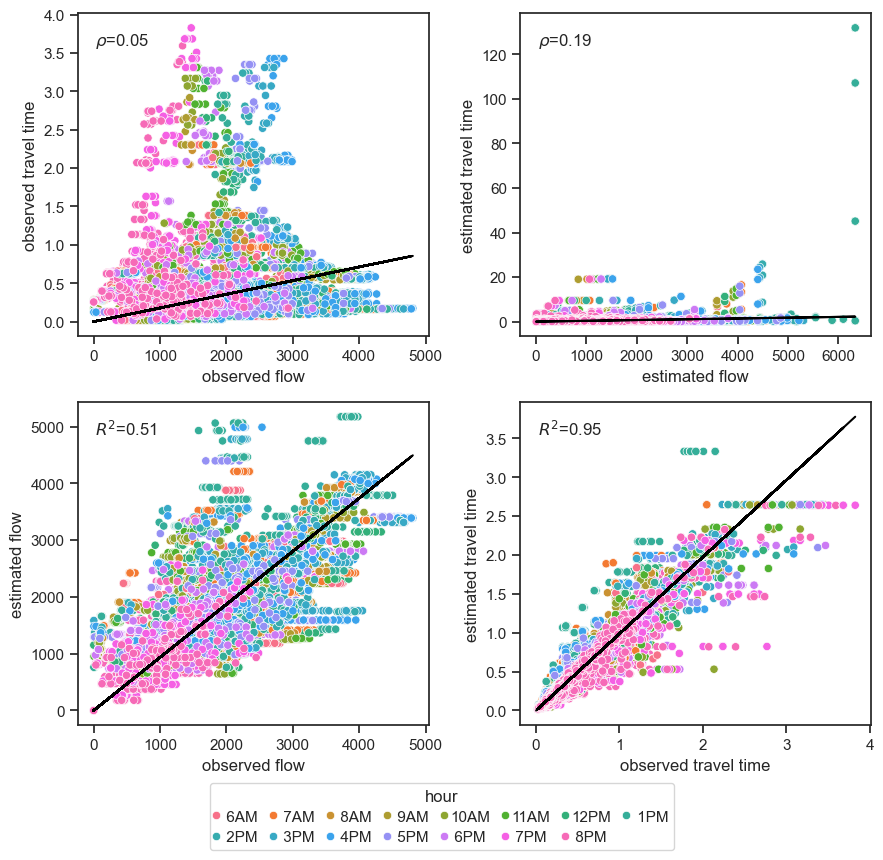

In [33]:
fig, axs = plot_flow_vs_traveltime(model = inference_models['tvodlulpe'],
                        observed_traveltime=inference_models['tvodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= inference_models['tvodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        period_col = pd.DataFrame({'period': list(XT_train[:, :, -1].numpy().astype(int).flatten())})['period'].
                                   map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

plt.show()

### -Make prediction on 2020, the validation set

In [34]:

_ = inference_models['tvodlulpe'].predict(XT_val,
                                          node_data=nodes_df,
                                          loss_metric=_LOSS_METRIC,
                                          batch_size= _BATCH_SIZE,
                                          optimizer= _OPTIMIZERS['tvodlulpe']['equilibrium'],
                                          pretrain_link_flows = False,
                                          loss_weights={'equilibrium': 1},
                                          threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                                          epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 15, batch size: 1, threshold relative gap: inf
training set -> timepoints: 195, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=1.9e+04, avg theta = [-3.648 -2.072  0.043 -4.242 -0.102 -2.925], avg rr = 0.57, avg theta fixed effect = 0.057, loss prop od=1.9e+03, total trips=[4.68e+04 5.04e+04 4.38e+04 4.51e+04 5.85e+04 5.37e+04 5.91e+04 6.10e+04
 6.73e+04 7.02e+04 7.03e+04 6.88e+04 6.74e+04 5.74e+04 5.57e+04], avg alpha=0.85, avg beta=2.7, lambda eq=1, relative gap=0.066, train equilibrium loss=1.9e+04, time: 5.0

Relative gap threshold of inf was achieved in equilibrium stage


In [35]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_models['tvodlulpe'].compute_loss_metrics(
        metrics = {_EVALUATION_METRIC.__name__: _EVALUATION_METRIC, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     20.9  mdape
1   traveltime     7.85  mdape
2  equilibrium     3.05  mdape
0         flow 4.03e+05    mse
1   traveltime  0.00574    mse
2  equilibrium 1.95e+04    mse
0         flow    0.293     r2
1   traveltime     0.91     r2
2  equilibrium    0.964     r2


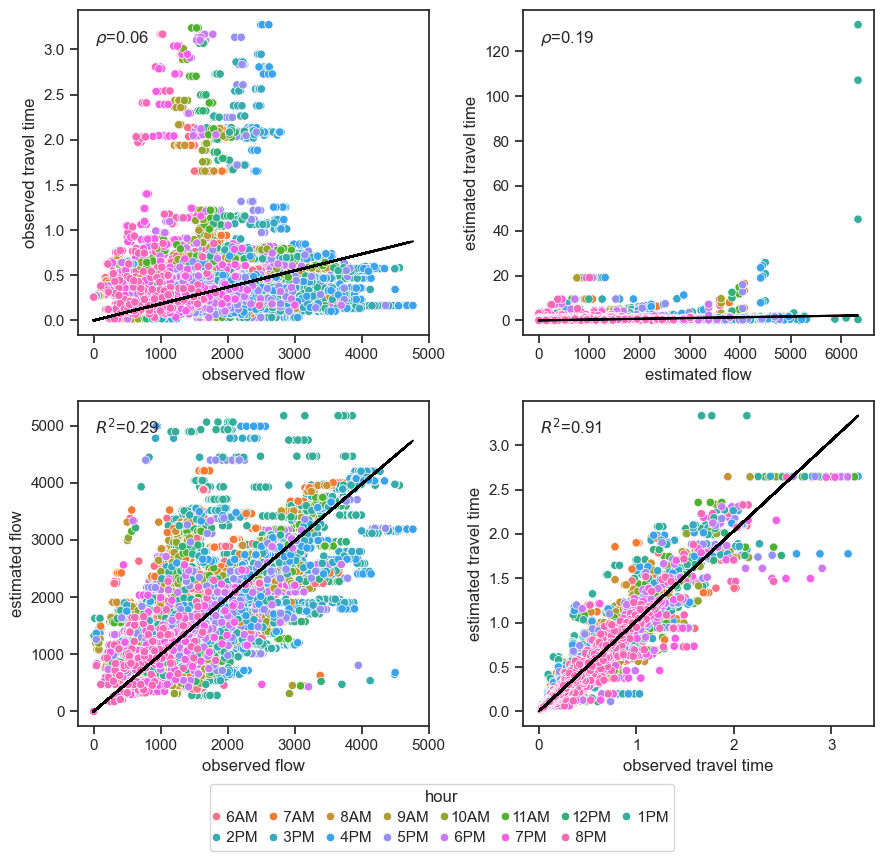

In [36]:
fig, axs = plot_flow_vs_traveltime(model = inference_models['tvodlulpe'],
                        observed_traveltime=inference_models['tvodlulpe'].mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_models['tvodlulpe'].mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].
                                   map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvodlulpe-without-equilibrium.png')

plt.show()

## K-Fold Cross Validation

In [37]:
models_kfold = {}
metrics_kfold_df = {}
parameters_kfold_df = {}

### - TVGODLULPE

In [ ]:
models_kfold['tvgodlulpe'] = create_tvgodlulpe_model_fresno(network = network, n_periods = n_periods, features_Z = _FEATURES_Z, reference_g = reference_g)
models_kfold['tvgodlulpe'].build()
models_kfold['tvgodlulpe'].generation._pretrain_generation_weights = True

# # Use pretrained weights
# models_kfold['tvgodlulpe'].load_weights(model_filepaths['tvgodlulpe'])
# models_kfold['tvgodlulpe'].generation._pretrain_generation_weights = False

# Assumed there is access to reference OD matrix
# q_reference = models_kfold['tvgodlulpe'].q

# Add historic OD from estimation in 2019
# models_kfold['tvgodlulpe'].od.historic_values = q_reference

In [ ]:
metrics_kfold_df['tvgodlulpe'], parameters_kfold_df['tvgodlulpe'] = train_kfold(
    n_splits=_N_SPLITS ,
    random_state = _SEED,
    model = models_kfold['tvgodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= _OPTIMIZERS['tvgodlulpe'],
    node_data = nodes_df,
    loss_weights=_LOSS_WEIGHTS_KFOLD['tvgodlulpe'],
    loss_metric=_LOSS_METRIC,
    evaluation_metric=_EVALUATION_METRIC,
    # epochs_print_interval= _EPOCHS['tvgodlulpe'].copy(),
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs = _EPOCHS['tvgodlulpe'],
)

In [ ]:
filename = f"{ts}_kfold_{network.key}.csv"
metrics_kfold_df['tvgodlulpe'].to_csv(f"./output/experiments/{filename}")
print(f"File {filename} written with k-fold results for TVGODULPE model")


# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvgodlulpe'][metrics_kfold_df['tvgodlulpe'].component.isin(['flow','traveltime'])], model_name = 'tvgodlulpe', metric_name = _EVALUATION_METRIC.__name__, showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig(f'output/figures/results/fresno-kfold-{_EVALUATION_METRIC.__name__}-tvgodlulpe.png')

plt.show()

In [ ]:
parameters_kfold_df['tvgodlulpe']['hour'] = parameters_kfold_df['tvgodlulpe'].period.replace({v: k for k, v in models_kfold['tvgodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvgodlulpe']['parameter'] = parameters_kfold_df['tvgodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvgodlulpe']['hour'] \
    = parameters_kfold_df['tvgodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvgodlulpe'].period_dict.items()})

parameters_kfold_df['tvgodlulpe'] = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True, rotation_xticks=90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvgodlulpe.png')

plt.show()

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvgodlulpe'][parameters_kfold_df['tvgodlulpe'].group == 'generation'], n_cols_legend = 3, figsize = (5.5,5.5), hour_label = True, rotation_xticks=90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-generation-periods-tvgodlulpe.png')

plt.show()

### - TVODLULPE

In [ ]:
models_kfold['tvodlulpe'] = create_tvodlulpe_model_fresno(network = network, n_periods = n_periods,
                                                          # reference_q = reference_q,
                                                          reference_q = flat_od_from_generated_trips(reference_g, ods = network.ods),
                                                          features_Z = _FEATURES_Z, dtype = _DTYPE)
models_kfold['tvodlulpe'].build()

# # Use pretrained weights
# models_kfold['tvodlulpe'].load_weights(model_filepaths['tvodlulpe'])

# Assumed there is access to reference OD matrix
# q_reference = models_kfold['tvodlulpe'].q

# Add historic OD from estimation in 2019
# models_kfold['tvodlulpe'].od.historic_values = q_reference

In [ ]:
metrics_kfold_df['tvodlulpe'], parameters_kfold_df['tvodlulpe'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state = _SEED,
    model = models_kfold['tvodlulpe'],
    X = XT_val, Y = YT_val,
    optimizers= _OPTIMIZERS['tvodlulpe'],
    node_data = nodes_df,
    loss_weights=_LOSS_WEIGHTS_KFOLD['tvodlulpe'],
    loss_metric=_LOSS_METRIC,
    evaluation_metric=_EVALUATION_METRIC,
    # epochs_print_interval= _EPOCHS['tvodlulpe'].copy(),
    threshold_relative_gap= _RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs = _EPOCHS['tvodlulpe'],
)

In [ ]:
metrics_kfold_df['tvodlulpe'].to_csv(f"./output/experiments/{ts}_kfold_{network.key}.csv")

# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

In [ ]:
fig, axs = plot_metrics_kfold(df = metrics_kfold_df['tvodlulpe'][metrics_kfold_df['tvodlulpe'].component.isin(['flow','traveltime'])],
                              metric_name = _EVALUATION_METRIC.__name__, model_name = 'tvodlulpe', showfliers = True)

for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig(f'output/figures/results/fresno-kfold-{_EVALUATION_METRIC.__name__}-tvodlulpe.png')

plt.show()

In [ ]:
parameters_kfold_df['tvodlulpe']['hour'] = parameters_kfold_df['tvodlulpe'].period.replace({v: k for k, v in models_kfold['tvodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold_df['tvodlulpe']['parameter'] = parameters_kfold_df['tvodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'median_inc': 'income', 'tt_sd': 'std. travel time', 'bus_stops': 'bus stops', 'vot': 'reliability ratio'})

parameters_kfold_df['tvodlulpe']['hour'] \
    = parameters_kfold_df['tvodlulpe']['period'].map({v:period_keys[period_keys.period_id == k]['hour'].iloc[0] for k,v in models_kfold['tvodlulpe'].period_dict.items()})

parameters_kfold_df['tvodlulpe'] = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold_df['tvodlulpe'][parameters_kfold_df['tvodlulpe'].group == 'utility'], n_cols_legend = 2, figsize = (5.5,5.5), hour_label = True, rotation_xticks=90)

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/results/fresno-kfold-utility-periods-tvodlulpe.png')

plt.show()

### - Baselines

In [ ]:
# Calculate centroids of links to compute baselines models
links_gdf['X'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).x
links_gdf['Y'] = links_gdf.to_crs(2228).geometry.centroid.to_crs(4326).y
coordinates = links_gdf[['X', 'Y']].values

In [ ]:
# Baselines are computed for every sample
metrics_kfold_df['baselines'] = pd.DataFrame({})
n_samples = XT_val.shape[0]

t0 = time.time()
for i in range(n_samples):

    isl.printer.printIterationBar(i+1, n_samples, prefix='Sample:',length=20)

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      metric=_EVALUATION_METRIC,
                                      X = XT_val[i],
                                      y = YT_val[i][:,0][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = _N_SPLITS, seed = _SEED).assign(component = 'traveltime')])

    metrics_kfold_df['baselines'] = pd.concat([metrics_kfold_df['baselines'],
                                  compute_baseline_predictions_kfold(
                                      metric=_EVALUATION_METRIC,
                                      X = XT_val[i],
                                      y = YT_val[i][:,1][tf.newaxis,:],
                                      coordinates = coordinates,
                                      n_splits = _N_SPLITS, seed = _SEED).assign(component = 'flow')])

    metrics_kfold_df['baselines']['sample'] = i

print(f'runtime: {time.time()-t0:0.1f} [s]')

In [ ]:
metrics_kfold_df['baselines'].to_csv(f"./output/experiments/{ts}_kfold_baselines_{network.key}.csv")

### Comparison between our model and benchmarks

In [ ]:
metrics_kfold_plot_df = metrics_kfold_df['tvgodlulpe'][
        (metrics_kfold_df['tvgodlulpe'].component != 'equilibrium') & (metrics_kfold_df['tvgodlulpe'].metric == _EVALUATION_METRIC.__name__) &
        (metrics_kfold_df['tvgodlulpe'].dataset == 'validation') & (metrics_kfold_df['tvgodlulpe'].stage == 'final')].\
        assign(model = 'tvgodlulpe')

In [ ]:
metrics_kfold_df['baselines'] \
    = metrics_kfold_df['baselines'].groupby(['fold', 'model', 'component'])[['value']].mean().reset_index()

metrics_kfold_plot_df = pd.concat([metrics_kfold_df['baselines'][['model','component','value']],
                                   metrics_kfold_plot_df[['model','component','value']]])

In [ ]:
means_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].mean().reset_index().rename(columns={'value':'mean'})
se_mapes = metrics_kfold_plot_df.groupby(['component','model'])['value'].agg(['std', 'count']).apply(lambda row: row['std'] / np.sqrt(row['count']), axis=1).reset_index().rename(columns={0:'se'})

pd.merge(means_mapes, se_mapes).sort_values(by = ['component', 'mean'])

In [ ]:
# Note: Result from ordinary kriging are removed due to unstable estimates and extremely large values of evaluation metric for travel time
plot_baselines_kfold(df = metrics_kfold_plot_df[metrics_kfold_plot_df.model != 'ordinary_kriging'],
                     metric_name=_EVALUATION_METRIC.__name__, sharex=True, sharey=True, showfliers = False)

plt.show()

### Predicted traffic congestion

In [ ]:
# Link-level spatial information
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin(_HOURS)) & (df['year']==2020)].sort_values(['period','link_key'])
# links_gdf = links_gdf.sort_values(['link_key'])

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow = plot_congestion_maps(model=inference_models['tvgodlulpe'], model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis', benchmark_model = 'regression_kriging')

In [ ]:
fig_flow

In [ ]:
fig_speed



## Global runtime

In [ ]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')